In [204]:
#we constrain the reionization speed "model-independe"

import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import time
import os
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
from scipy.optimize import fsolve

import antisym_func
import error_bar #Tan
import error #Zhou

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
from importlib import reload
reload(error_bar); reload(error)

<module 'error' from '/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/error.py'>

In [162]:
hlittle = (0.678)
Ho = hlittle*3.2407e-18
OMb  = (0.0492) 
G = (6.67259e-8)
CMperMPC = (3.086e24)
Msun = (1.989e33)
Y_He = (0.245)
m_p = (1.6726231e-24)
RHOcrit = ( (3.0*Ho*Ho / (8.0*np.pi*G)) * (CMperMPC*CMperMPC*CMperMPC)/Msun)
RHOcrit_cgs = (3.0*Ho*Ho / (8.0*np.pi*G))
No  = (RHOcrit_cgs*OMb*(1-Y_He)/m_p)
He_No = (RHOcrit_cgs*OMb*Y_He/(4.0*m_p))
f_He = (He_No/(No)) 

In [163]:
OMb*hlittle*hlittle

(1.9179530190806878e-07, 0.08112582781456953)

In [298]:
def setting_models(zeta, T_vir, R_mfp):
    """
    compute set the reionization model and gain its history
    -----------
    Parameters:
    -----------
    zeta : the ionizating efficiency
    T_vir : K, the virial temperature
    R_mfp : Mpc, the maximum radius of ionized bubbles
    --------
    Returns:
    --------
    zeta_z_func : the normalized zeta with respect to the redshift
    z_history, HI_history: the neutral fraction with respect to the redshift
    z_dxHdz_history, dxHdz_history : the reionization speed dx_HI/dz with respect to the redshift 
    max_speed : the maximum reionization speed
    turning_redshift : the redshift when the reionization speed reaches its maximum
    """
    tick = time.time()
    M_max = antisym_func.RtoM(R_mfp)
    mu = 1.22 if T_vir < 9.99999e3 else 0.6
    NUM = 60; z_zeta_interp_array = np.linspace(5.5, 16, NUM); zeta_z_interp_array = []
    for i in range(NUM):
        zeta_z_interp_array.append(antisym_func.zeta_z(z_zeta_interp_array[i], zeta, T_vir, mu))
    zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    z_history = np.linspace(5.5, 16, 200); HI_history = [];
    for z in z_history:
        HI_history.append(1 - antisym_func.bar_Q(z, M_max, zeta_z_func, T_vir, mu, antisym_func.PARA_z(z, M_max, zeta_z_func, T_vir, mu)))
    [z_dxHdz_history, dxHdz_history] = antisym_func.dxH_dz_cal(z_history, HI_history)
    max_speed = max(dxHdz_history)
    turning_redshift = z_dxHdz_history[dxHdz_history.index(max_speed)]  
    print('history comuputation at zeta=%3.3g T_vir=%3.3g cost %3.3g seconds'%(zeta, T_vir, time.time() - tick))
    return zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift

def tau(z_ion_he2, Delta_z_he2, z_history, HI_history):
    """
    compute the optical depth of elctron scattering (eqn 85 in Planck 2018:VI)
    -----------
    Parameters:
    -----------
    z : redshift we are interested in
    z_ion1, z_ion2 : the first and second helium reionization redshift, presumebly 3.5 and 7
    Delta_z1, Delta_z2 : the duaration of the helium reionization period, roughly 0.5
    z_history, HI_history: the neutral fraction with respect to the redshift
    --------
    Returns:
    --------
    x_e : the number density ratio of free electrons and hydrogen nuclei
    """
    f_He = 0.0811 #the number density ratio of helium to hydrogen nuclei, from 21cmFAST-v1.3
    n_H0 = 1.91795e-07 #cm^(-3), the intergalactic medium hydrogen number density from 21cmFAST-v1.3
    sigma_T = 6.6524e-25 #cm^2, Thomson scattering cross section
    c_speed = 29979245800.0 #cm * s^(-1)
    
    #compute the he number density of free electrons from helium second ionization only and hydrogen nuclei
    Y_z = lambda z: (1 + z)**1.5
    Delta_y = lambda z, Delta_z: 1.5 * (1 + z)**0.5 * Delta_z
    x_e_helium = lambda z, z_ion, Delta_z: \
        f_He / 2 * (1 + np.tanh((Y_z(z_ion) - Y_z(z)) / Delta_y(z_ion, Delta_z))) 
    #compute the he number density of free electrons from hydrogen ionization only and hydrogen nuclei
    HI_func = interp1d(z_history, HI_history, kind = 'cubic')
    def x_e_hydrogen(z):
        if z < min(z_history): return 1
        elif z > max(z_history): return 0
        else:
            return 1 - HI_func(z)
        #+ x_e_helium(z, z_ion_he1, Delta_z_he1) 
    integrand = lambda z: (x_e_helium(z, z_ion_he2, Delta_z_he2) \
                          + (1+f_He) * x_e_hydrogen(z)) * (1 + z)**2 / (antisym_func.H_z(z) / 3.08567758128e19) #H(z) unit from km/s/Mpc to /s
    return n_H0 * sigma_T * c_speed * integrate.quad(integrand, 0, 15, epsrel = 1e-3)[0]

def model_constraint(max_speed_solution, tau_solution, zeta_assumed, T_vir_assumed,):
    def model_computation(parameters, xtol = 0.0001):
        zeta = parameters[0]; T_vir = parameters[1]
        eta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
            = setting_models(zeta, T_vir, 50)
        tau_0 = tau(3.5, 0.5, z_history, HI_history)
        HI_func = interp1d(z_history, HI_history, kind = 'cubic')
        print('max_speed =', max_speed, 'tau =', tau_0, 'HI(z=5.9) =', HI_func(5.9))
        return [max_speed - max_speed_solution, tau_0 - tau_solution]
    zeta, T_vir = fsolve(model_computation, [zeta_assumed, T_vir_assumed])
    eta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
            = setting_models(zeta, T_vir, 50)
    HI_func = interp1d(z_history, HI_history, kind = 'cubic')
    if HI_func(5.9) > 0.11:
        print("the model is constraint by the ending time of reionization")
        def model_computation(parameters, xtol = 0.0001):
            zeta = parameters[0]; T_vir = parameters[1]
            eta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
                = setting_models(zeta, T_vir, 50)
            tau_0 = tau(3.5, 0.5, z_history, HI_history)
            HI_func = interp1d(z_history, HI_history, kind = 'cubic')
            print('max_speed =', max_speed, 'tau =', tau_0, 'HI(z=5.9) =', HI_func(5.9))
            return [max_speed - max_speed_solution, HI_func(5.9) - 0.11]
        zeta, T_vir = fsolve(model_computation, [zeta_assumed, T_vir_assumed])
        return zeta, T_vir
    return zeta, T_vir

In [299]:
model_constraint(0.36, 0.0440, 21.3, 8e4)

history comuputation at zeta=21.3 T_vir=8e+04 cost 10.5 seconds
max_speed = 0.3872495337755133 tau = 0.05402158298716704 HI(z=5.9) = 0.1030675414359601
history comuputation at zeta=21.3 T_vir=8e+04 cost 10.4 seconds
max_speed = 0.3872495337755133 tau = 0.05402158298716704 HI(z=5.9) = 0.1030675414359601
history comuputation at zeta=21.3 T_vir=8e+04 cost 10.1 seconds
max_speed = 0.3872495337755133 tau = 0.05402158298716704 HI(z=5.9) = 0.1030675414359601
history comuputation at zeta=21.3 T_vir=8e+04 cost 10.1 seconds
max_speed = 0.3872495336893468 tau = 0.05402158323467139 HI(z=5.9) = 0.10306753190926042
history comuputation at zeta=21.3 T_vir=8e+04 cost 10.1 seconds
max_speed = 0.3872495349576006 tau = 0.05402158277473185 HI(z=5.9) = 0.10306754735394813
history comuputation at zeta=0.892 T_vir=4.69e+04 cost 10.9 seconds
max_speed = 0.02158643343338078 tau = 0.03602473480005476 HI(z=5.9) = 0.9567134659550769
history comuputation at zeta=9.62 T_vir=8.1e+04 cost 9.9 seconds
max_speed = 0.24

(16.968828073944973, 55148.16423374904)

In [294]:
zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift \
= setting_models(14.5 , 4.08e4, 50)
print('tau =', tau(3.5, 0.5, z_history, HI_history), '\n', 'max_speed =',max_speed,'z_turn = ', turning_redshift)
HI_func = interp1d(z_history, HI_history, kind = 'cubic'); 
print('x_HI(z=5.9) =',HI_func(5.9)); print('x_HI(z=11) =',HI_func(11))

history comuputation at zeta=14.5 T_vir=4.08e+04 cost 10.9 seconds
tau = 0.0471835902192016 
 max_speed = 0.3401117009548917 z_turn =  6.106783919597991
x_HI(z=5.9) = 0.11027262628469041
x_HI(z=11) = 0.9339611746931163


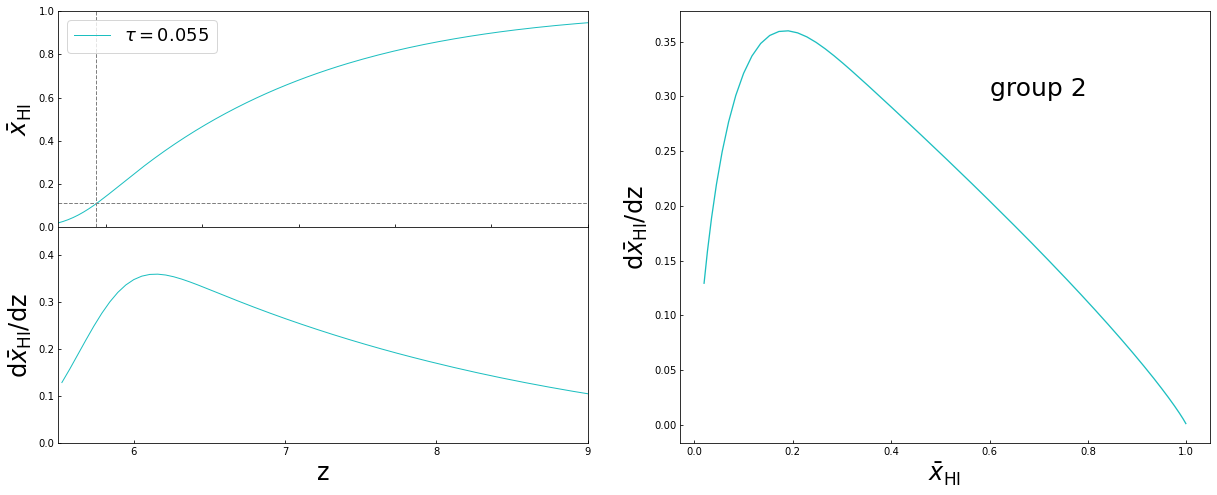

In [309]:
#plot the reionization history of group 2
zeta_z_func, z_history, HI_history, z_dxHdz_history, dxHdz_history, max_speed, turning_redshift = \
[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]
zeta_array = [16.97]; T_vir_array = [5.51]
tau_array = [0.055]
for i in range(1):
    zeta = zeta_array[i]; T_vir = T_vir_array[i]
    zeta_z_func[i], z_history[i], HI_history[i], z_dxHdz_history[i], dxHdz_history[i], \
        max_speed[i], turning_redshift[i] = setting_models(zeta, T_vir * 1e4, 50)

plt.figure(figsize=(16,6))
FONTSIZE = 24
ax1 = plt.subplot(221, position=[0,1,0.46,0.5])
max_dxHdz_array = [0.33, 0.36, 0.39, 0.42]
colorlist=['#1CBFC0', '#634CBC', '#DA4267', '#F87D31']; stylelist = ['-', '--', '-.']
ax1.tick_params(direction='in',length=3)
for i in range(1):
    ax1.plot(z_history[i], HI_history[i], color = colorlist[i], lw=1, label=r'$\tau = %4.4g $'%(tau_array[i]))
ax1.legend(fontsize=18, loc = 2)
ax1.set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=FONTSIZE)
ax1.set_ylim(0,1)
ax1.set_xlim(5.5,9)
ax1.set_xticks([6,7,8,9,10,11])
ax1.set_xticklabels([])
ax1.axvline(x=5.9, lw = 1, color='grey', ls = '--')
ax1.axhline(y=0.11, lw = 1, color='grey', ls = '--')

ax2 = plt.subplot(223, position=[0,0.5,0.46,0.5])
for i in range(1):
    ax2.plot(z_dxHdz_history[i], dxHdz_history[i], color = colorlist[i], lw=1)
ax2.set_ylim(0.0,0.46); ax2.set_xlim(5.8,11.2)
ax2.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax2.set_xlabel('z',fontsize=FONTSIZE)
ax2.tick_params(direction='in',length=3)
ax2.set_xticks([6,7,8,9,10,11])
ax2.set_xticklabels(['6','7','8','9','10','11'])
ax2.set_xlim(5.5,9)

ax3 = plt.subplot(122, position=[0.54,0.5,0.46,1])
lwlist = [1.3, 0.8, 0.3]
for i in range(1):
    ax3.plot(HI_history[i][:-1], dxHdz_history[i], color = colorlist[i], lw=lwlist[i])
ax3.set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=FONTSIZE)
ax3.set_xlabel(r'$\bar{x}_\mathrm{HI}$',fontsize=FONTSIZE)
ax3.tick_params(direction='in',length=3)
#ax3.text(0.6, 0.3, 'group 2', fontsize = 25)
plt.savefig('../figures/history_groups_20230222.png', bbox_inches = 'tight', dpi=400)